In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

We do -1 to take the batch size as it is and reshape the 784 into 1 x 28 x 28

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.13195078125, tensor(0.2522)]
valid: [1.8506740234375, tensor(0.3928)]
CPU times: user 8.76 s, sys: 500 ms, total: 9.26 s
Wall time: 3.44 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [15]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [16]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(device),self.yb.to(device)

In [17]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [18]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [1.929224375, tensor(0.3122, device='cuda:0')]
valid: [0.602099609375, tensor(0.8127, device='cuda:0')]
train: [0.418687890625, tensor(0.8735, device='cuda:0')]
valid: [0.2357996337890625, tensor(0.9245, device='cuda:0')]
train: [0.19204361328125, tensor(0.9428, device='cuda:0')]
valid: [0.1467422607421875, tensor(0.9544, device='cuda:0')]
CPU times: user 4.28 s, sys: 1.39 s, total: 5.68 s
Wall time: 6.76 s


Now, that's definitely faster!

## Refactor model

First we can regroup all the conv/relu in a single function:

In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [26]:
5//2

2

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [27]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [28]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [29]:
# number of filters per layer
nfs = [8,16,32,32]

### First kernal size is 5 versus 3 so that we have 25 inputs for our 8 outputs rather than not doing much on first layer by going from 9 to 8.  Otherwise we are wasting calculations/time.

In [30]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
#         we make the first kernal size 5 versus 3 so that have 25 inputs for our 8 outputs.  with filter size of 3 would have 9 inputs for 8 outputs
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [31]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [32]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [33]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [34]:
run.fit(3, learn)

train: [1.7808578125, tensor(0.3885, device='cuda:0')]
valid: [0.672296533203125, tensor(0.7910, device='cuda:0')]
train: [0.3765695703125, tensor(0.8845, device='cuda:0')]
valid: [0.19778848876953126, tensor(0.9404, device='cuda:0')]
train: [0.1892822265625, tensor(0.9423, device='cuda:0')]
valid: [0.14253828125, tensor(0.9565, device='cuda:0')]


## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [35]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [36]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [37]:
run.fit(2, learn)

train: [1.93946765625, tensor(0.3159, device='cuda:0')]
valid: [0.680136962890625, tensor(0.7661, device='cuda:0')]
train: [0.3409485546875, tensor(0.8938, device='cuda:0')]
valid: [0.20166864013671876, tensor(0.9404, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

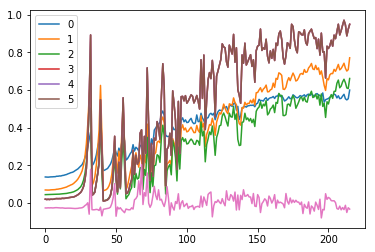

In [38]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

The above looks really bad. Our means are going out of control quickly and then stabilizing after some time (since activations went really small). We probably lost info when it came back down from that spike.

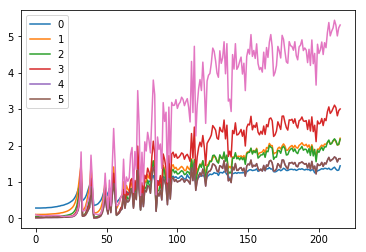

In [39]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

Similarly here, our standard deviations are getting out of control and then coming back down.

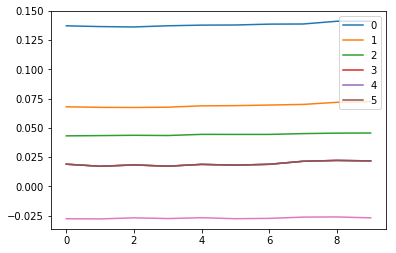

In [42]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

We see above that our means are not near 0.

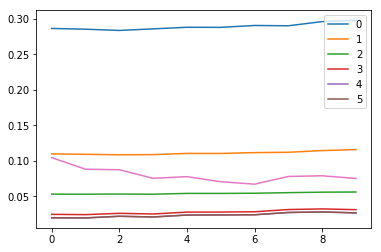

In [43]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

We see above that our standard deviations are getting further and further from 1 with each layer.

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

In [44]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [45]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [46]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [47]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [48]:
run.fit(1, learn)

train: [1.84446203125, tensor(0.3586, device='cuda:0')]
valid: [0.617334033203125, tensor(0.7803, device='cuda:0')]


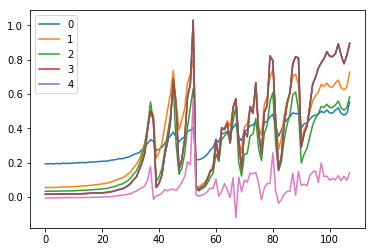

In [49]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [50]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [51]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

### want to focus on conv2d layers

In [52]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [53]:
run.fit(1, learn)

train: [2.2457115625, tensor(0.1891, device='cuda:0')]
valid: [1.8406869140625, tensor(0.3703, device='cuda:0')]


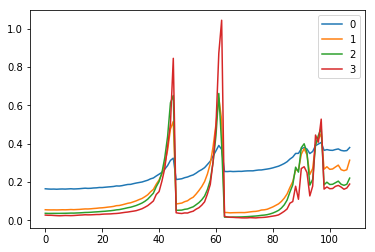

In [54]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

In [55]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [56]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [57]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [58]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [59]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
#         will be called at beginning when call Hooks with "with"
    def __enter__(self, *args): return self
#     automatically called when with block is done
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [60]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [61]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fb7b00729e8>, <__main__.Hook object at 0x7fb7b0030b70>, <__main__.Hook object at 0x7fb7b0030a90>, <__main__.Hook object at 0x7fb7b00309b0>, <__main__.Hook object at 0x7fb7b10dddd8>, <__main__.Hook object at 0x7fb7b10dd048>, <__main__.Hook object at 0x7fb7b10dd5c0>]

In [62]:
hooks.remove()

In [63]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [64]:
x.mean(),x.std()

(tensor(-0.0117, device='cuda:0'), tensor(0.9881, device='cuda:0'))

In [65]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1718, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3840, device='cuda:0', grad_fn=<StdBackward0>))

In [66]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [67]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3843, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.8959, device='cuda:0', grad_fn=<StdBackward0>))

Much better now that we have used kaiming init. Our mean is close to 0.5 (which we want because of the relu) and std dev near 1.

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [2.33945765625, tensor(0.1871, device='cuda:0')]
valid: [2.3056908203125, tensor(0.1064, device='cuda:0')]
train: [2.25477, tensor(0.1531, device='cuda:0')]
valid: [2.1049744140625, tensor(0.3026, device='cuda:0')]


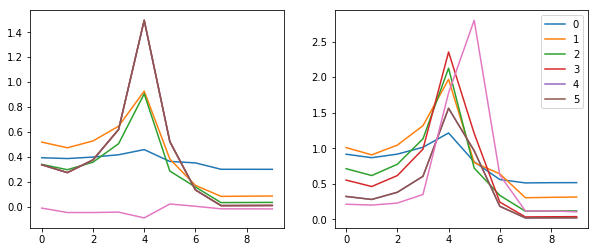

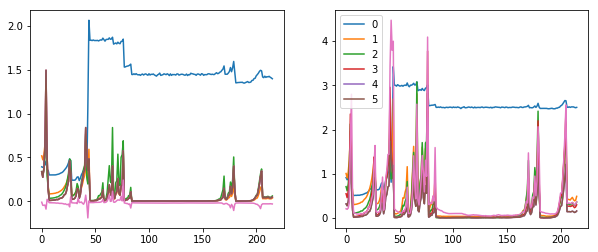

In [68]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

### Plots looking better since we did proper initialization.  Don't have a bunch of initial exponential growth and crash sequences and standard deviations in first 10 batches looking closer to 1. But still not showing us if something is going wrong in training and what that is. Really want to see if we have activations that are going to 0. A histogram of the activations will help us see whether we have activations going to 0 and the spread of the activations.

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

In [69]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
#    creates histogram of the activations. 40 bins going from 0 to 10. don't need to go below 0 because have relu
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

Even though we are going to initialize the parameters here, we are doing a learning rate too high. Will have same result -- activations going to 0

In [72]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [73]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [74]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.89576625, tensor(0.3275, device='cuda:0')]
valid: [0.57533994140625, tensor(0.8202, device='cuda:0')]


In [75]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

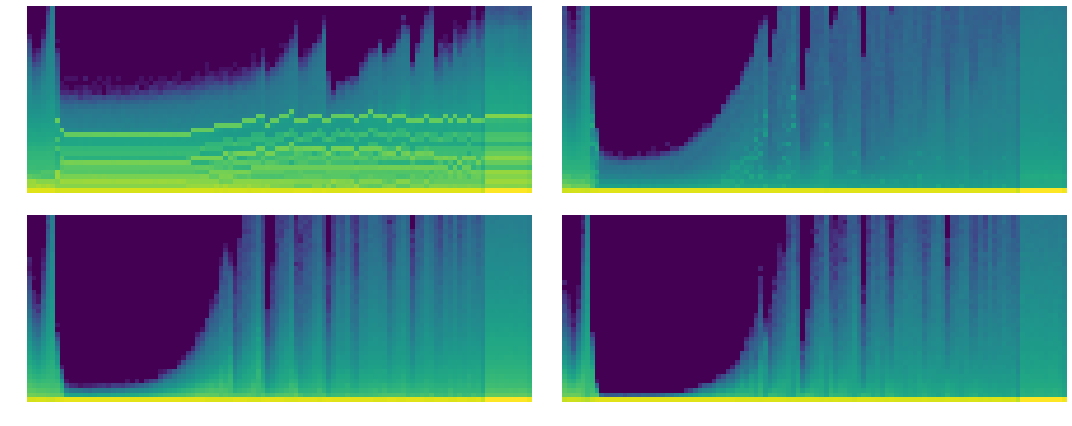

In [76]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

### Yellow is where we have the most activations.  We see here a lot of yellow at 0 which is bad.  X axis is iterations.  Y asxis is value of the activations.

In [79]:
torch.tensor([1, 2, 3]).sum(0)

tensor(6)

From the histograms, we can easily get more informations like the min or max of the activations

In [80]:
# This function tells us what % of the activations are 0 or nearly 0. we are taking the number of values in or 0, 1 buckets over all values 
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

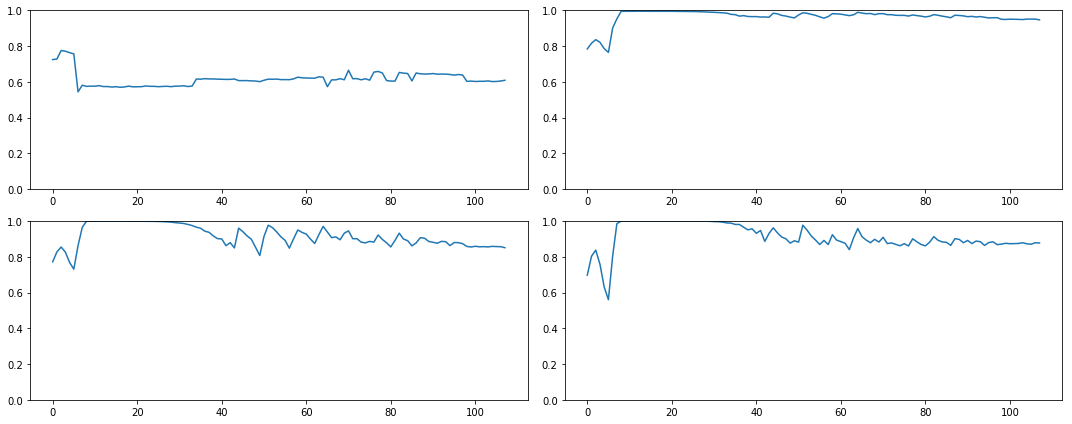

In [81]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

The above plots what % of the activations are 0 or near 0 in the first 4 layers. top left is first layer, bottom left is second layer, top right is third layer, bottom right is fourth layer. Almost all activations are 0 by 4th layer.

## Generalized ReLU

### Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

#### so to perform better, we will try leaky relu, setting amount to subtract from relu and setting a max on relu

In [82]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

### Now that we are subtracting from relu and have leaky relu need our histogram to go negative to capture activations

In [108]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
#     note range of bins. we want 40 bins going from -7 to 7
    hists.append(outp.data.cpu().histc(40,-7,7))

In [85]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.508813671875, tensor(0.8406, device='cuda:0')]
valid: [0.229560205078125, tensor(0.9280, device='cuda:0')]


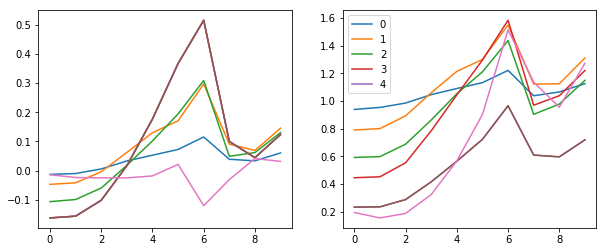

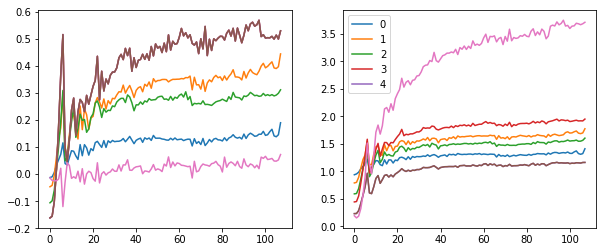

In [86]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

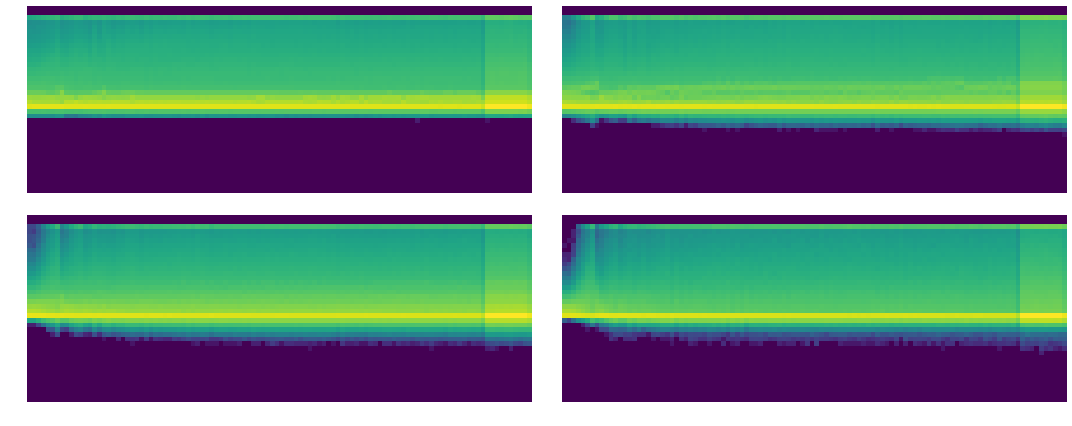

In [87]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

#### Above results are much better even though using high learning rate. We are using the full area for activations (we have some yellow/green all the way to the top). We don't see the crashes anymore.  Let's graph the % of yellow at or near 0 to see if we really are keeping the activations away from going to 0.

### Since we allow leaky relu and subtracting for relu, to pick up the bins with activations at 0, we actually want the middle bins now.

In [88]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

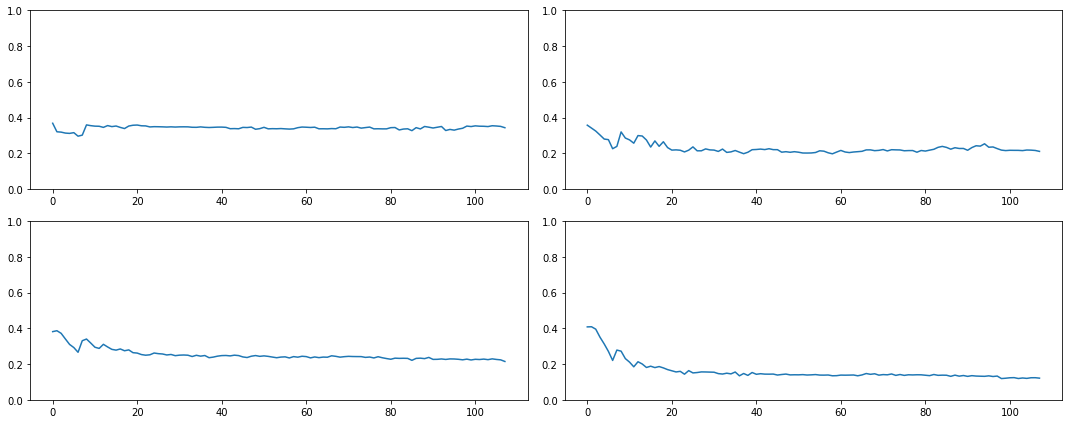

In [89]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

### Doing much better -- layer 4 has less than 20% of the activations at or near 0!

In [90]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [91]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [92]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [93]:
run.fit(8, learn)

train: [1.05905234375, tensor(0.6686, device='cuda:0')]
valid: [0.2758816650390625, tensor(0.9174, device='cuda:0')]
train: [0.29651568359375, tensor(0.9123, device='cuda:0')]
valid: [0.202802783203125, tensor(0.9374, device='cuda:0')]
train: [0.25191931640625, tensor(0.9232, device='cuda:0')]
valid: [0.124203076171875, tensor(0.9632, device='cuda:0')]
train: [0.158731875, tensor(0.9511, device='cuda:0')]
valid: [0.1606304931640625, tensor(0.9532, device='cuda:0')]
train: [0.101367607421875, tensor(0.9703, device='cuda:0')]
valid: [0.0941004150390625, tensor(0.9755, device='cuda:0')]
train: [0.0604605810546875, tensor(0.9813, device='cuda:0')]
valid: [0.07787841796875, tensor(0.9787, device='cuda:0')]
train: [0.0453829638671875, tensor(0.9868, device='cuda:0')]
valid: [0.07002918090820312, tensor(0.9808, device='cuda:0')]
train: [0.03763377197265625, tensor(0.9889, device='cuda:0')]
valid: [0.06705498657226562, tensor(0.9820, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

### Some people say uniform distribution is better for initialization than is normal since less change of values at or near 0 to start.  Doesn't seem to make much of a difference in this experiment.

In [94]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [95]:
run.fit(8, learn)

train: [1.011511484375, tensor(0.6823, device='cuda:0')]
valid: [0.2555560546875, tensor(0.9275, device='cuda:0')]
train: [0.3422440234375, tensor(0.8999, device='cuda:0')]
valid: [0.18825501708984374, tensor(0.9448, device='cuda:0')]
train: [0.29785611328125, tensor(0.9125, device='cuda:0')]
valid: [0.2058608154296875, tensor(0.9388, device='cuda:0')]
train: [0.1196572265625, tensor(0.9633, device='cuda:0')]
valid: [0.09961248779296875, tensor(0.9703, device='cuda:0')]
train: [0.091178984375, tensor(0.9719, device='cuda:0')]
valid: [0.08639603881835937, tensor(0.9762, device='cuda:0')]
train: [0.054939951171875, tensor(0.9831, device='cuda:0')]
valid: [0.064126171875, tensor(0.9799, device='cuda:0')]
train: [0.041223955078125, tensor(0.9876, device='cuda:0')]
valid: [0.060412445068359376, tensor(0.9818, device='cuda:0')]
train: [0.033741025390625, tensor(0.9903, device='cuda:0')]
valid: [0.0594357421875, tensor(0.9825, device='cuda:0')]


In [ ]:
# experiments

In [98]:
def getHooks(model, append_stats, epochs, runner, learner):
    with Hooks(model, append_stats) as hooks:
        runner.fit(epochs, learner)
    return hooks

In [99]:
def plotHooks(hooks):
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [100]:
def plotHistogramHooks(hooks):
    fig,axes = plt.subplots(2,2, figsize=(15,6))
    for ax,h in zip(axes.flatten(), hooks[:4]):
        ax.imshow(get_hist(h), origin='lower')
        ax.axis('off')
        plt.tight_layout()

In [105]:
def plotPercentZeroes(hooks, startZeroes, endZeroes):
    def get_min(h):
        h1 = torch.stack(h.stats[2]).t().float()
        return h1[startZeroes:endZeroes].sum(0)/h1.sum(0)
    fig,axes = plt.subplots(2,2, figsize=(15,6))
    for ax,h in zip(axes.flatten(), hooks[:4]):
        ax.plot(get_min(h))
        ax.set_ylim(0,1)
    plt.tight_layout()

In [ ]:
# jeremy's model that got 98%:
# model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)

In [151]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=8.)
init_cnn(model)

In [152]:
cbfs.append(partial(ParamScheduler,'lr', sched))

In [153]:
# learner,runner = get_learn_run(nfs, data, .9, conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])
learner,runner = get_runner(model, data, lr=0.9, cbs=cbfs)

In [154]:
hooks = getHooks(model, append_stats, 1, runner, learner)

train: [0.699205703125, tensor(0.7793, device='cuda:0')]
valid: [0.1702763671875, tensor(0.9496, device='cuda:0')]


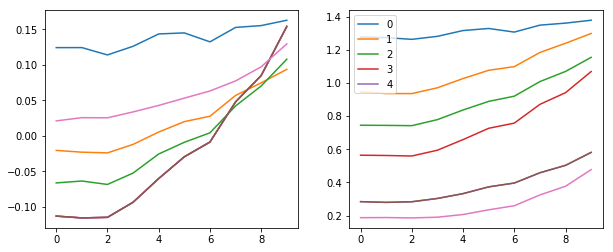

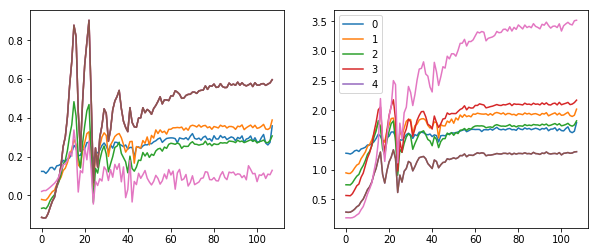

In [155]:
plotHooks(hooks)

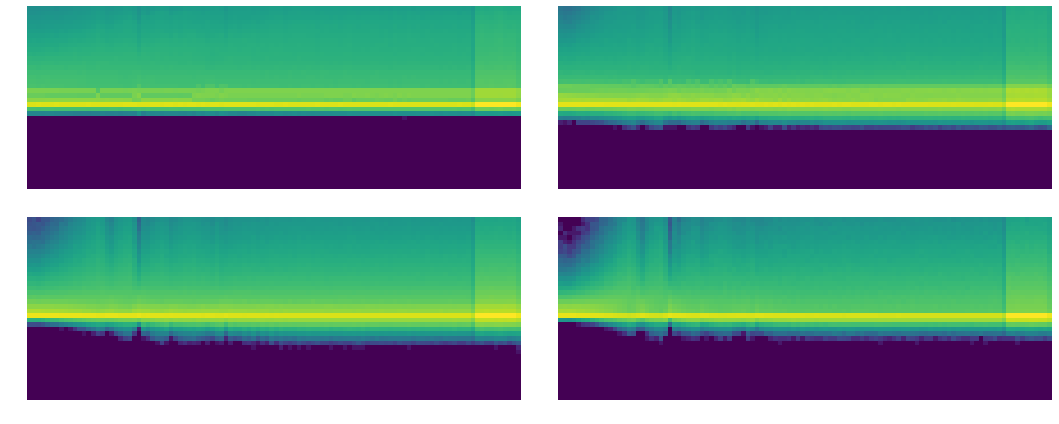

In [156]:
plotHistogramHooks(hooks)

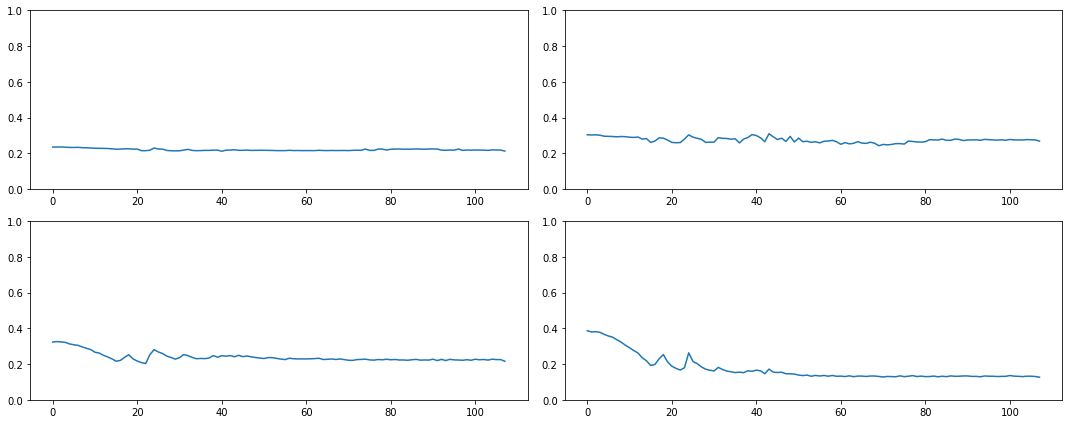

In [157]:
plotPercentZeroes(hooks, 19, 22)

In [158]:
runner.fit(8, learner)

train: [0.1688215234375, tensor(0.9492, device='cuda:0')]
valid: [0.14021968994140624, tensor(0.9607, device='cuda:0')]
train: [0.13550369140625, tensor(0.9591, device='cuda:0')]
valid: [0.1282797607421875, tensor(0.9620, device='cuda:0')]
train: [0.120370234375, tensor(0.9624, device='cuda:0')]
valid: [0.09590819702148437, tensor(0.9715, device='cuda:0')]
train: [0.3344115625, tensor(0.9410, device='cuda:0')]
valid: [139.5310375, tensor(0.0983, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [ ]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()

<IPython.core.display.Javascript object>